# Imports

In [79]:
# Remote data access for pandas
import pandas_datareader as webreader
# Mathematical functions 
import math 
# Fundamental package for scientific computing with Python
import numpy as np 
# Additional functions for analysing and manipulating data
import pandas as pd 
# Date Functions
from datetime import date, timedelta, datetime
# This function adds plotting functions for calender dates
from pandas.plotting import register_matplotlib_converters
# Important package for visualization - we use this to plot the market data
import matplotlib.pyplot as plt 
# Formatting dates
import matplotlib.dates as mdates
# Packages for measuring model performance / errors
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Deep learning library, used for neural networks
from keras.models import Sequential 
# Deep learning classes for recurrent and regular densely-connected layers
from keras.layers import LSTM, Dense, Dropout
# EarlyStopping during model training
from keras.callbacks import EarlyStopping
# This Scaler removes the median and scales the data according to the quantile range to normalize the price data 
from sklearn.preprocessing import RobustScaler
# GridSearch Functions and K-Folds for cross-validation
from sklearn.model_selection import GridSearchCV, KFold
# For detailed configuration of the optimizer 
from keras.optimizers import Adam
# KerasRegressor warpper class
from keras.wrappers.scikit_learn import KerasRegressor

# Loading the Data

In [94]:
# Setting the timeframe for the data extraction
today = date.today()
date_today = today.strftime("%Y-%m-%d")
date_start = '2010-01-01'

# Getting NASDAQ quotes
stockname = 'NASDAQ'
symbol = '^IXIC'
df = webreader.DataReader(
    symbol, start=date_start, end=date_today, data_source="yahoo"
)

# Quick overview of dataset
train_dfs = df.copy()

# We will only use the Closing and Date Column
train_dfs = train_dfs[['Close']]

train_dfs

,Close
Date,
2010-01-04,2308.419922
2010-01-05,2308.709961
2010-01-06,2301.090088
2010-01-07,2300.050049
2010-01-08,2317.169922
...,...
2020-06-23,10131.370117
2020-06-24,9909.169922
2020-06-25,10017.000000


# Feature Engineering

In [95]:
# Indexing Batches
train_df = train_dfs.sort_values(by=['Date']).copy()

# We safe a copy of the dates index, before we need to reset it to numbers
date_index = train_df.index
date_index_df = pd.DataFrame(date_index)

# Adding Month and Year in separate columns
d = pd.to_datetime(train_df.index)
train_df['Day'] = d.strftime("%d") 
train_df['Month'] = d.strftime("%m") 
train_df['Year'] = d.strftime("%Y") 

# We reset the index, so we can convert the date-index to a number-index
train_df.reset_index(level=0, inplace=True)
train_df.tail(5)

,Date,Close,Day,Month,Year
2635,2020-06-23,10131.370117,23,06,2020
2636,2020-06-24,9909.169922,24,06,2020
2637,2020-06-25,10017.000000,25,06,2020
2638,2020-06-26,9757.219727,26,06,2020
2639,2020-06-29,9839.348633,29,06,2020


In [97]:
# Feature Engineering
def createFeatures(df):
    df = pd.DataFrame(df)

    #--- Moving averages - different periods
    df['MA200'] = df['Close'].rolling(window=200).mean() 
    df['MA100'] = df['Close'].rolling(window=100).mean() 
    df['MA50'] = df['Close'].rolling(window=50).mean() 
    df['MA26'] = df['Close'].rolling(window=26).mean() 
    df['MA20'] = df['Close'].rolling(window=20).mean() 
    df['MA12'] = df['Close'].rolling(window=12).mean() 
    
    # Exponential Moving Averages
    df['EMA20'] = df['Close'].ewm(span=20, adjust=False).mean()
    df['EMA100'] = df['Close'].ewm(span=100, adjust=False).mean()
    df['EMA200'] = df['Close'].ewm(span=200, adjust=False).mean()
    
    #replace nas 
    nareplace = df.at[df.index.max(), 'Close']    
    df.fillna((nareplace), inplace=True)
    
    return df

             Close       Date        EMA20    Prediction
2635  10131.370117 2020-06-23  9738.024432  10131.370117
2636   9909.169922 2020-06-24  9754.324002   9909.169922
2637  10017.000000 2020-06-25  9779.340764  10017.000000
2638   9757.219727 2020-06-26  9777.233998   9757.219727
2639   9839.348633 2020-06-29  9783.149678   9839.348633


<function matplotlib.pyplot.show(*args, **kw)>

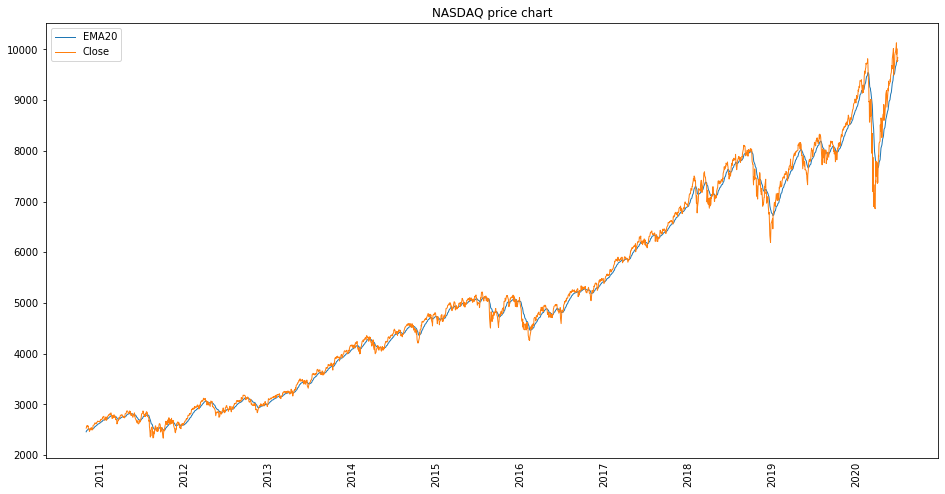

In [103]:
# List of considered Features
FEATURES = [
            'Close',
#             'Volume',
            'Date',
#             'Day',
#             'Month',
#             'Year',
#             'MA200',
#             'MA100',            
#             'MA50',
#             'MA26',
#             'MA12',
            'EMA20',
#             'EMA100',
#             'EMA200'
           ]

# Create the dataset with features
data = createFeatures(train_df)

# Shift the timeframe by 10 month
use_start_date = pd.to_datetime("2010-11-01" )
data = data[data['Date'] > use_start_date].copy()

# Filter the data to the list of FEATURES
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Close'] 
print(data_filtered_ext.tail().to_string())


# remove Date column before training
dfs = data_filtered_ext.copy()
del dfs[('Date')]
del dfs[('Prediction')]

# Register matplotlib converters
register_matplotlib_converters()

# Define plot parameters 
nrows = dfs.shape[1]
fig, ax = plt.subplots(figsize=(16, 8))
x = data_filtered_ext['Date']
assetname_list = []

# Plot each column
for i in range(nrows):
    assetname = dfs.columns[i-1]
    y = data_filtered_ext[assetname]
    ax.plot(x, y, label=assetname, linewidth=1.0)
    assetname_list.append(assetname)

# Configure and show the plot    
ax.set_title(stockname + ' price chart')
ax.legend()
ax.tick_params(axis="x", rotation=90, labelsize=10, length=0)   
plt.show

# Scaling and Transforming the Data

In [107]:
# Calculate the number of rows in the data
nrows = dfs.shape[0]
np_data_unscaled = np.reshape(np.array(dfs), (nrows, -1))
print(np_data_unscaled.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = RobustScaler()
np_data = scaler.fit_transform(np_data_unscaled)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = RobustScaler()
df_Close = pd.DataFrame(data_filtered_ext['Close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)



(2430, 2)


In [108]:
# Define Sequence Length
sequence_length = 30

# Get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(np_data.shape[0] * 0.8) 
print(train_data_len)

# Create the training data with 80% of the full dataset
train_data = np_data[0:train_data_len, :]
x_train, y_train = [], []

# The RNN needs data with the format of [samples, time steps, features].
# Here, we create N samples, sequence_length time steps per sample, and z features
for i in range(sequence_length, train_data_len):
    x_train.append(train_data[i-sequence_length:i,:]) #contains n values 0-sequence_length * columns
    y_train.append(train_data[i, 0]) #contains the prediction values for validation

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Create the test data with the remaining 20% of the dataset
test_data = np_data[train_data_len - sequence_length:, :]

# Split the test data into x_test and y_test
x_test, y_test = [], []
test_data_len = test_data.shape[0]
print(test_data_len)
for i in range(sequence_length, test_data_len):
    x_test.append(test_data[i-sequence_length:i,:]) #contains n values 0-sequence_length * columns
    y_test.append(test_data[i, 0]) #contains the prediction values for validation
    
# Convert the x_train and y_train to numpy arrays
x_test, y_test = np.array(x_test), np.array(y_test)

# Convert the x_train and y_train to numpy arrays
x_test = np.array(x_test); y_test = np.array(y_test)

# Print Shapes
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

1944
516
(1914, 30, 2) (1914,)
(486, 30, 2) (486,)


# Hyper-parameter-tuning using Grid Search

In [174]:
def create_model(loss, epochs, learn_rate):
   # Configure the neural network model
    model = Sequential()

    # Model with n Neurons 
    # inputshape = t Timestamps x f Features
    n_neurons = x_train.shape[1] * x_train.shape[2]
    print('timesteps: ' + str(x_train.shape[1]) + ',' + ' features:' + str(x_train.shape[2]))
    model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
    model.add(LSTM(n_neurons, return_sequences=True))
    model.add(LSTM(n_neurons, return_sequences=False))
    model.add(Dense(10))
    model.add(Dense(1, activation='relu'))

    adam = Adam(lr=learn_rate)
    optimizer = adam
                 
    # Compile and Training the model
    model.compile(optimizer=optimizer, loss=loss)
    return model

# Create the model
model = KerasRegressor(build_fn=create_model)

In [178]:
# Parameters
learn_rate = [0.001, 0.01]
adam = Adam(lr=learn_rate)
optimizer = ['adam']
epochs = [25, 1];
batch_size = [16];
patience = 5;
loss= ['mean_squared_error'];
plist = []
slist = []
param_grid = dict(
                  loss=loss,
                  epochs=epochs,
                  learn_rate=learn_rate)

# Build the gridsearch
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=KFold(n_splits = 2, random_state=45, shuffle=True), verbose=10)

early_stop = EarlyStopping(monitor='loss', patience=patience, verbose=1)
grid_results = grid.fit(x_train, y_train, epochs=25, batch_size=4, callbacks=[early_stop], shuffle = True)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] epochs=25, learn_rate=0.001, loss=mean_squared_error ............
timesteps: 30, features:2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/25
1531/1531 [==============================] - 17s 11ms/step - loss: 0.1070
Epoch 2/25
1531/1531 [==============================] - 16s 10ms/step - loss: 0.1063
Epoch 3/25
1531/1531 [==============================] - 17s 11ms/step - loss: 0.1060
Epoch 4/25
1531/1531 [==============================] - 17s 11ms/step - loss: 0.1058
Epoch 5/25
1531/1531 [==============================] - 16s 11ms/step - loss: 0.1058
Epoch 6/25
1531/1531 [==============================] - 16s 10ms/step - loss: 0.1057
Epoch 7/25
1531/1531 [==============================] - 18s 11ms/step - loss: 0.1057
Epoch 8/25
1531/1531 [==============================] - 17s 11ms/step - loss: 0.1058
Epoch 9/25
1531/1531 [==============================] - 17s 11ms/step - loss: 0.1056
Epoch 10/25
1531/1531 [==============================] - 20s 13ms/step - loss: 0.1055
Epoch 11/25
1531/1531 [==============================] - 17s 11ms/step - loss: 0.1056 0s - loss: 0.1
Epoch 12/25
1531/1531 [=========================

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.3min remaining:    0.0s


Epoch 1/25
1531/1531 [==============================] - 20s 13ms/step - loss: 0.1076
Epoch 2/25
1531/1531 [==============================] - 20s 13ms/step - loss: 0.1063
Epoch 3/25
1531/1531 [==============================] - 17s 11ms/step - loss: 0.1066
Epoch 4/25
1531/1531 [==============================] - 17s 11ms/step - loss: 0.1062
Epoch 5/25
1531/1531 [==============================] - 16s 11ms/step - loss: 0.1061
Epoch 6/25
1531/1531 [==============================] - 16s 11ms/step - loss: 0.1060
Epoch 7/25
1531/1531 [==============================] - 16s 11ms/step - loss: 0.1060
Epoch 8/25
1531/1531 [==============================] - 16s 10ms/step - loss: 0.1059
Epoch 9/25
1531/1531 [==============================] - 16s 10ms/step - loss: 0.1059
Epoch 10/25
1531/1531 [==============================] - 17s 11ms/step - loss: 0.1059
Epoch 11/25
1531/1531 [==============================] - 17s 11ms/step - loss: 0.1058
Epoch 12/25
1531/1531 [==============================] - 17s 11

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  8.9min remaining:    0.0s


Epoch 1/25
1531/1531 [==============================] - 19s 12ms/step - loss: 0.1040
Epoch 2/25
1531/1531 [==============================] - 17s 11ms/step - loss: 0.1022
Epoch 3/25
1531/1531 [==============================] - 17s 11ms/step - loss: 0.1024
Epoch 4/25
1531/1531 [==============================] - 17s 11ms/step - loss: 0.1020
Epoch 5/25
1531/1531 [==============================] - 17s 11ms/step - loss: 0.1018 0s - los
Epoch 6/25
1531/1531 [==============================] - 17s 11ms/step - loss: 0.1019
Epoch 7/25
1531/1531 [==============================] - 19s 13ms/step - loss: 0.1018
Epoch 8/25
1531/1531 [==============================] - 19s 13ms/step - loss: 0.1017
Epoch 9/25
1531/1531 [==============================] - 19s 12ms/step - loss: 0.1016
Epoch 10/25
1531/1531 [==============================] - 18s 12ms/step - loss: 0.1016
Epoch 11/25
1531/1531 [==============================] - 21s 14ms/step - loss: 0.1016
Epoch 12/25
1531/1531 [==============================]

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 17.2min remaining:    0.0s


Epoch 1/25
1531/1531 [==============================] - 20s 13ms/step - loss: 0.1072
Epoch 2/25
1531/1531 [==============================] - 19s 13ms/step - loss: 0.1062
Epoch 3/25
1531/1531 [==============================] - 20s 13ms/step - loss: 0.1058
Epoch 4/25
1531/1531 [==============================] - 21s 14ms/step - loss: 0.1058 
Epoch 5/25
1531/1531 [==============================] - 18s 12ms/step - loss: 0.1056
Epoch 6/25
1531/1531 [==============================] - 18s 12ms/step - loss: 0.1057 1s - ETA: 0s - loss: 0.1
Epoch 7/25
1531/1531 [==============================] - 18s 12ms/step - loss: 0.1055
Epoch 8/25
1531/1531 [==============================] - 18s 12ms/step - loss: 0.1055
Epoch 9/25
1531/1531 [==============================] - 18s 12ms/step - loss: 0.1054
Epoch 10/25
1531/1531 [==============================] - 17s 11ms/step - loss: 0.1054
Epoch 11/25
1531/1531 [==============================] - 17s 11ms/step - loss: 0.1054
Epoch 12/25
1531/1531 [==============

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 23.1min remaining:    0.0s


Epoch 1/25
1532/1532 [==============================] - 22s 14ms/step - loss: 0.1079
Epoch 2/25
1532/1532 [==============================] - 19s 12ms/step - loss: 0.1065
Epoch 3/25
1532/1532 [==============================] - 19s 12ms/step - loss: 0.1064
Epoch 4/25
1532/1532 [==============================] - 20s 13ms/step - loss: 0.1066
Epoch 5/25
1532/1532 [==============================] - 20s 13ms/step - loss: 0.1062
Epoch 6/25
1532/1532 [==============================] - 21s 14ms/step - loss: 0.1062
Epoch 7/25
1532/1532 [==============================] - 21s 14ms/step - loss: 0.1061
Epoch 8/25
1532/1532 [==============================] - 23s 15ms/step - loss: 0.1061
Epoch 9/25
1532/1532 [==============================] - 22s 14ms/step - loss: 0.1062
Epoch 10/25
1532/1532 [==============================] - 21s 14ms/step - loss: 0.1061
Epoch 11/25
1532/1532 [==============================] - 21s 14ms/step - loss: 0.1060
Epoch 12/25
1532/1532 [==============================] - 19s 13

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 29.6min remaining:    0.0s


Epoch 1/25
1531/1531 [==============================] - 21s 14ms/step - loss: 0.1613
Epoch 2/25
1531/1531 [==============================] - 21s 14ms/step - loss: 0.1592
Epoch 3/25
1531/1531 [==============================] - 21s 14ms/step - loss: 0.1592
Epoch 4/25
1531/1531 [==============================] - 19s 12ms/step - loss: 0.1592
Epoch 5/25
1531/1531 [==============================] - 23s 15ms/step - loss: 0.1592
Epoch 6/25
1531/1531 [==============================] - 18s 12ms/step - loss: 0.1592
Epoch 7/25
1531/1531 [==============================] - 21s 14ms/step - loss: 0.1592
Epoch 8/25
1531/1531 [==============================] - 21s 14ms/step - loss: 0.1592
Epoch 9/25
1531/1531 [==============================] - 22s 14ms/step - loss: 0.1592
Epoch 10/25
1531/1531 [==============================] - 20s 13ms/step - loss: 0.1592
Epoch 11/25
1531/1531 [==============================] - 19s 13ms/step - loss: 0.1592
Epoch 12/25
1531/1531 [==============================] - 19s 12

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 34.4min remaining:    0.0s


Epoch 1/25
1531/1531 [==============================] - 21s 14ms/step - loss: 0.1594
Epoch 2/25
1531/1531 [==============================] - 21s 13ms/step - loss: 0.1595
Epoch 3/25
1531/1531 [==============================] - 22s 14ms/step - loss: 0.1595
Epoch 4/25
1531/1531 [==============================] - 21s 14ms/step - loss: 0.1595
Epoch 5/25
1531/1531 [==============================] - 21s 14ms/step - loss: 0.1595
Epoch 6/25
1531/1531 [==============================] - 26s 17ms/step - loss: 0.1595
Epoch 00006: early stopping
383/383 [==============================] - 2s 4ms/step
[CV]  epochs=25, learn_rate=0.01, loss=mean_squared_error, score=-0.156, total= 2.3min
[CV] epochs=25, learn_rate=0.01, loss=mean_squared_error .............
timesteps: 30, features:2


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 36.6min remaining:    0.0s


Epoch 1/25
1531/1531 [==============================] - 25s 16ms/step - loss: 0.1588
Epoch 2/25
1531/1531 [==============================] - 18s 12ms/step - loss: 0.1568
Epoch 3/25
1531/1531 [==============================] - 16s 11ms/step - loss: 0.1568
Epoch 4/25
1531/1531 [==============================] - 18s 11ms/step - loss: 0.1568
Epoch 5/25
1531/1531 [==============================] - 17s 11ms/step - loss: 0.1568
Epoch 6/25
1531/1531 [==============================] - 17s 11ms/step - loss: 0.1568
Epoch 7/25
1531/1531 [==============================] - 16s 10ms/step - loss: 0.1568
Epoch 8/25
1531/1531 [==============================] - 16s 10ms/step - loss: 0.1568
Epoch 9/25
1531/1531 [==============================] - 16s 11ms/step - loss: 0.1568
Epoch 10/25
1531/1531 [==============================] - 17s 11ms/step - loss: 0.1568
Epoch 11/25
1531/1531 [==============================] - 16s 11ms/step - loss: 0.1568
Epoch 12/25
1531/1531 [==============================] - 16s 11

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 41.9min remaining:    0.0s


Epoch 1/25
1531/1531 [==============================] - 20s 13ms/step - loss: 0.1605
Epoch 2/25
1531/1531 [==============================] - 17s 11ms/step - loss: 0.1607
Epoch 3/25
1531/1531 [==============================] - 19s 12ms/step - loss: 0.1607
Epoch 4/25
1531/1531 [==============================] - 17s 11ms/step - loss: 0.1607
Epoch 5/25
1531/1531 [==============================] - 18s 12ms/step - loss: 0.1607
Epoch 6/25
1531/1531 [==============================] - 18s 12ms/step - loss: 0.1607
Epoch 00006: early stopping
383/383 [==============================] - 1s 2ms/step
[CV]  epochs=25, learn_rate=0.01, loss=mean_squared_error, score=-0.151, total= 1.8min
[CV] epochs=25, learn_rate=0.01, loss=mean_squared_error .............
timesteps: 30, features:2


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 43.7min remaining:    0.0s


Epoch 1/25
1532/1532 [==============================] - 25s 16ms/step - loss: 0.1585
Epoch 2/25
1532/1532 [==============================] - 22s 14ms/step - loss: 0.1579
Epoch 3/25
1532/1532 [==============================] - 22s 14ms/step - loss: 0.1579 0s - loss: 
Epoch 4/25
1532/1532 [==============================] - 21s 14ms/step - loss: 0.1579
Epoch 5/25
1532/1532 [==============================] - 23s 15ms/step - loss: 0.1579
Epoch 6/25
1532/1532 [==============================] - 21s 14ms/step - loss: 0.1579
Epoch 7/25
1532/1532 [==============================] - 21s 14ms/step - loss: 0.1579
Epoch 8/25
1532/1532 [==============================] - 21s 14ms/step - loss: 0.1579
Epoch 9/25
1532/1532 [==============================] - 22s 14ms/step - loss: 0.1579
Epoch 10/25
1532/1532 [==============================] - 22s 14ms/step - loss: 0.1579
Epoch 11/25
1532/1532 [==============================] - 22s 14ms/step - loss: 0.1579
Epoch 12/25
1532/1532 [============================

1531/1531 [==============================] - 17s 11ms/step - loss: 0.1055
Epoch 8/25
1531/1531 [==============================] - 16s 11ms/step - loss: 0.1056
Epoch 9/25
1531/1531 [==============================] - 16s 11ms/step - loss: 0.1054
Epoch 10/25
1531/1531 [==============================] - 16s 11ms/step - loss: 0.1056
Epoch 11/25
1531/1531 [==============================] - 16s 10ms/step - loss: 0.1054
Epoch 12/25
1531/1531 [==============================] - 16s 11ms/step - loss: 0.1054
Epoch 13/25
1531/1531 [==============================] - 16s 11ms/step - loss: 0.1055
Epoch 14/25
1531/1531 [==============================] - 16s 11ms/step - loss: 0.1054
Epoch 15/25
1531/1531 [==============================] - 16s 11ms/step - loss: 0.1054
Epoch 16/25
1531/1531 [==============================] - 17s 11ms/step - loss: 0.1053
Epoch 17/25
1531/1531 [==============================] - 18s 12ms/step - loss: 0.1054
Epoch 18/25
1531/1531 [==============================] - 17s 11ms/st

KeyboardInterrupt: 

In [156]:
# Summarize the results in a readable format
print("Best: {0}, using {1}".format(grid_results.cv_results_['mean_test_score'], grid_results.best_params_))

pd.DataFrame(grid_results.cv_results_)

Best: [-0.10511705 -0.15883011 -0.15883011 -0.15883011 -0.10526174 -0.15883011
 -0.15883011 -0.15883011], using {'epochs': 1, 'learn_rate': 0.001, 'loss': 'mean_squared_error'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_epochs,param_learn_rate,param_loss,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,17.334626,0.387704,0.538816,0.015320,1,0.001,mean_squared_error,"{'epochs': 1, 'learn_rate': 0.001, 'loss': 'me...",-0.102618,-0.101361,-0.118239,-0.102917,-0.100438,-0.105117,0.006623,1
1,17.848712,0.423149,0.543438,0.016418,1,0.02,mean_squared_error,"{'epochs': 1, 'learn_rate': 0.02, 'loss': 'mea...",-0.157484,-0.156088,-0.166926,-0.151292,-0.162369,-0.158830,0.005372,3
2,17.753405,0.131441,0.556212,0.025380,1,0.2,mean_squared_error,"{'epochs': 1, 'learn_rate': 0.2, 'loss': 'mean...",-0.157484,-0.156088,-0.166926,-0.151292,-0.162369,-0.158830,0.005372,3
3,17.853182,0.155814,0.567471,0.002957,1,0.1,mean_squared_error,"{'epochs': 1, 'learn_rate': 0.1, 'loss': 'mean...",-0.157484,-0.156088,-0.166926,-0.151292,-0.162369,-0.158830,0.005372,3
4,36.235669,3.646349,0.605410,0.011394,2,0.001,mean_squared_error,"{'epochs': 2, 'learn_rate': 0.001, 'loss': 'me...",-0.102767,-0.101222,-0.118706,-0.103040,-0.100560,-0.105262,0.006788,2
5,37.677093,1.741420,0.639969,0.036096,2,0.02,mean_squared_error,"{'epochs': 2, 'learn_rate': 0.02, 'loss': 'mea...",-0.157484,-0.156088,-0.166926,-0.151292,-0.162369,-0.158830,0.005372,3
6,38.607399,1.901120,0.660407,0.038080,2,0.2,mean_squared_error,"{'epochs': 2, 'learn_rate': 0.2, 'loss': 'mean...",-0.157484,-0.156088,-0.166926,-0.151292,-0.162369,-0.158830,0.005372,3
7,36.549247,1.235948,0.672053,0.044684,2,0.1,mean_squared_error,"{'epochs': 2, 'learn_rate': 0.1, 'loss': 'mean...",-0.157484,-0.156088,-0.166926,-0.151292,-0.162369,-0.158830,0.005372,3


# Visualize Model Performance

486/486 [==============================] - 0s 913us/step
Mean Absolute Percentage Error (MAPE): 5.97 %
Median Absolute Percentage Error (MDAPE): 5.27 %
Mean Absolute Error (MAE): 503.7246
Mean Squared Error (MSE): 378248.4382


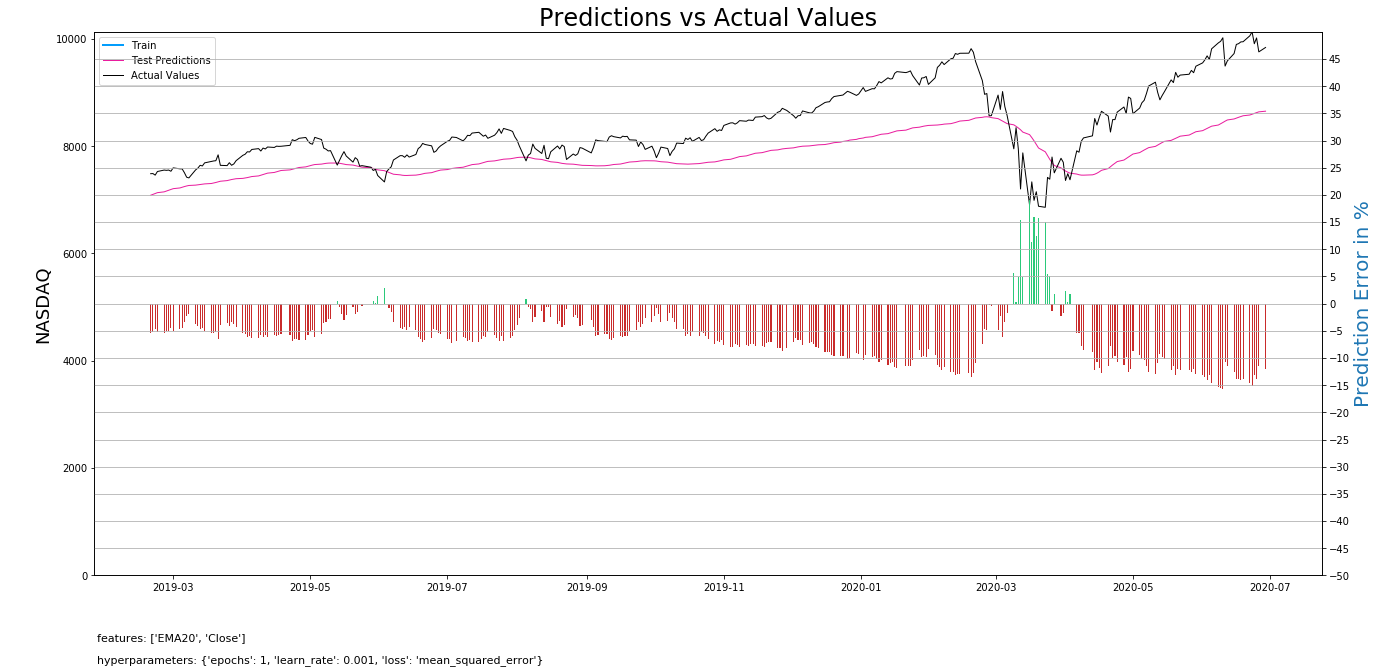

<Figure size 432x288 with 0 Axes>

In [157]:
# Get the best Model
bestmodel = grid_results.best_estimator_
parameter_list = grid_results.best_params_

# Get the predicted values
y_pred = bestmodel.predict(x_test)

# Get the predicted values
pred_unscaled = scaler_pred.inverse_transform(y_pred.reshape(-1, 1))
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, pred_unscaled)/ y_test_unscaled))) * 100
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, pred_unscaled)/ y_test_unscaled)) ) * 100
print('Median Absolute Percentage Error (MDAPE): ' + str(np.round(MDAPE, 2)) + ' %')

# Mean Absolute Error (MAE)
print('Mean Absolute Error (MAE): ' + str(np.round(mean_absolute_error(y_test_unscaled, pred_unscaled), 4)))

# Mean Squared Error (MSE)
print('Mean Squared Error (MSE): ' + str(np.round(mean_squared_error(y_test_unscaled, pred_unscaled), 4)))

# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=500)

# Add the date column
data_filtered_sub = data_filtered.copy()
# Shift the timeframe by 10 month
date_index = date_index_df[date_index_df['Date'] > use_start_date].copy()
data_filtered_sub['Date'] = date_index

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", pred_unscaled.ravel(), True)
valid.insert(1, "Percentage Deviation", (valid["Prediction"] - valid["Close"]) * 100 / valid["Close"], True)

# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=24)
plt.ylabel(stockname, fontsize=18)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=1.0)
plt.plot(xv, yv["Close"], color="black", linewidth=1.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Percentage Deviation"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

#Configure Axis 1
ax1.set_ylim([0,max(valid["Close"])])

#Configure Axis 2
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Prediction Error in %', color='tab:blue', fontsize=20)  # we already handled the x-label with ax1
ax2.tick_params(axis='y')
ax2.set_yticks(np.arange(-50, 50, 5.0))
ax2.set_ylim([-50,50])
plt.bar(x, y, width=0.5, color=valid['diff_color'])

ax1.annotate('features: ' + str(assetname_list), xy=(0.07, .04), xycoords='figure fraction', 
    horizontalalignment='left', verticalalignment='bottom', fontsize=11)
ax1.annotate('hyperparameters: ' + str(parameter_list), xy=(0.07, .005), xycoords='figure fraction', 
    horizontalalignment='left', verticalalignment='bottom', fontsize=11)
#Plot the chart
plt.grid()
plt.show()
plt.savefig('test')